Đang tải dữ liệu cho 30 mã cổ phiếu và VN30 ETF...


C:\Users\admin\AppData\Local\Temp\ipykernel_1828\2462520169.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(YF_TICKERS, start=START_DATE, end=END_DATE, progress=False)
C:\Users\admin\AppData\Local\Temp\ipykernel_1828\2462520169.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  m_data = yf.download(MARKET_TICKER, start=START_DATE, end=END_DATE, progress=False)['Close'].ffill()


✅ Hoàn tất Bước 1. Đã lưu 5430 dòng (với 'volume') vào C:\Users\admin\PycharmProjects\wht\data\stock_prices_raw.csv.
Đang chạy scraper cho 9 trang báo... (Việc này có thể mất nhiều giờ)


Đang cào dữ liệu các trang:   0%|          | 0/9 [00:00<?, ?it/s]2025-11-20 23:29:56,860 - INFO - --- Bắt đầu chạy scrape_cafef ---
2025-11-20 23:29:57,720 - INFO - Phân tích Sitemap Index: https://cafef.vn/sitemap.xml
2025-11-20 23:29:59,435 - INFO - Phân tích Sitemap Links: https://cafef.vn/sitemaps/sitemaps-2025-9-1-5.xml
2025-11-20 23:30:08,989 - WARNING - Không thể tải https://cafef.vn/vpbank-hop-tac-ping-an-xay-dung-he-thong-ngan-hang-loi-xu-ly-1-ty-giao-dich-ngay-188250905184837041.chn: 404 Client Error: Not Found for url: https://cafef.vn/vpbank-hop-tac-ping-an-xay-dung-he-thong-ngan-hang-loi-xu-ly-1-ty-giao-dich-ngay-188250905184837041.chn
2025-11-20 23:32:24,723 - INFO - Phân tích Sitemap Links: https://cafef.vn/sitemaps/sitemaps-2025-9-6-10.xml
2025-11-20 23:34:18,824 - INFO - Phân tích Sitemap Links: https://cafef.vn/sitemaps/sitemaps-2025-9-11-15.xml
2025-11-20 23:36:03,918 - INFO - Phân tích Sitemap Links: https://cafef.vn/sitemaps/sitemaps-2025-9-16-20.xml
2025-11-20 23:

✅ Hoàn tất Bước 2. Đã lưu 25245 bài viết vào C:\Users\admin\PycharmProjects\wht\data\news_raw.csv.

--- BƯỚC 3: PHÂN TÍCH CẢM XÚC (PHOBERT LOCAL) ---
-> Đang tải và phân loại dữ liệu...
-> Phân loại xong. Tổng số bài cần chấm điểm: 23192
⏳ Đang tải model PhoBERT...


Device set to use cpu


🚀 Bắt đầu chấm điểm bằng PhoBERT...


Tiến độ PhoBERT: 100%|██████████| 23192/23192 [19:47<00:00, 19.53it/s]


✅ HOÀN TẤT BƯỚC 3! Lưu tại: C:\Users\admin\PycharmProjects\wht\data\news_scored.csv

--- BƯỚC 4: HỢP NHẤT DỮ LIỆU PANEL ---
-> Đang hợp nhất dữ liệu...
        Date ticker       ret    volume  market_ret  sent_firm  sent_macro
0 2025-01-03    ACB -0.019724  25634673   -0.013711   0.989039    0.095557
1 2025-01-03    BID  0.000000   3698500   -0.013711        NaN    0.095557
2 2025-01-03    BVH -0.034571   1174600   -0.013711        NaN    0.095557
3 2025-01-03    CTG -0.023906  10418500   -0.013711        NaN    0.095557
4 2025-01-03    EIB -0.027029   5154900   -0.013711        NaN    0.095557
✅ Hoàn tất Bước 4. Đã lưu file panel: C:\Users\admin\PycharmProjects\wht\data\panel_data.csv (5430 dòng).

--- BƯỚC 5: CHẠY MÔ HÌNH VÀ KIỂM ĐỊNH VIF ---
------------------------------------------------------------
>>> MÔ HÌNH 1A: FIXED EFFECTS (CƠ BẢN) <<<
------------------------------------------------------------
                          PanelOLS Estimation Summary                           

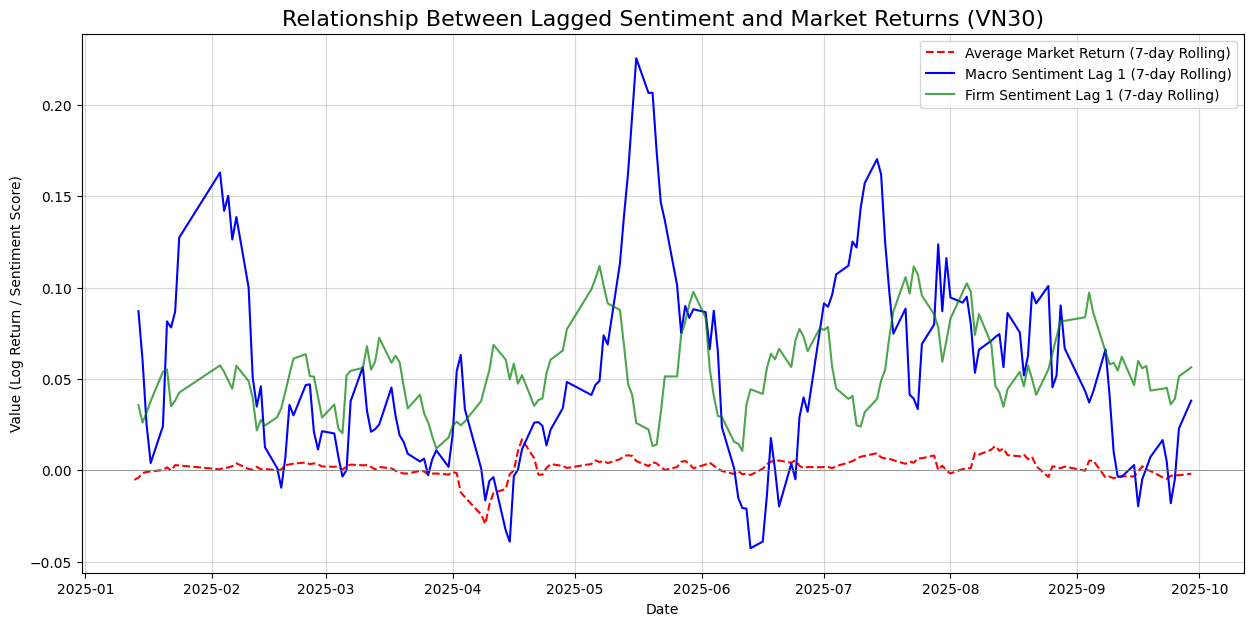

✅ Plot generated successfully.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import logging
from linearmodels.panel import PanelOLS
from linearmodels.iv import IVGMM
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import pipeline
from linearmodels.panel import RandomEffects, PooledOLS
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.panel import compare

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

PROJECT_PATH = r"C:\Users\admin\PycharmProjects\wht"
DATA_PATH = os.path.join(PROJECT_PATH, "data")
if not os.path.exists(DATA_PATH):
  os.makedirs(DATA_PATH)

FILE_STOCK = os.path.join(DATA_PATH, "stock_prices_raw.csv")
FILE_NEWS_RAW = os.path.join(DATA_PATH, "news_raw.csv")
FILE_NEWS_SCORED = os.path.join(DATA_PATH, "news_scored.csv")
FILE_PANEL = os.path.join(DATA_PATH, "panel_data.csv")

START_DATE = "2025-01-01"
END_DATE = "2025-09-30"
VN30 = ["ACB", "BID", "BVH", "CTG", "EIB", "FPT", "GAS", "GVR", "HDB", "HPG", "KDH", "MBB", "MSN", "MWG", "NVL", "PDR", "PLX", "POW", "SAB", "SSI", "STB", "TCB", "TPB", "VCB", "VHM", "VIB", "VIC", "VJC", "VNM", "VPB"]
YF_TICKERS = [f"{t}.VN" for t in VN30]
MARKET_TICKER = "E1VFVN30.VN"

if os.path.exists(FILE_STOCK):
  print(f"\n✅ [CHECKPOINT] Đã có file giá: {FILE_STOCK}. Bỏ qua Bước 1.")
  print("⚠️ LƯU Ý: Nếu file này thiếu 'volume', hãy XÓA file và chạy lại cell này.")
else:
  try:
    print(f"Đang tải dữ liệu cho {len(VN30)} mã cổ phiếu và VN30 ETF...")

    raw_data = yf.download(YF_TICKERS, start=START_DATE, end=END_DATE, progress=False)

    m_data = yf.download(MARKET_TICKER, start=START_DATE, end=END_DATE, progress=False)['Close'].ffill()
    if m_data.empty: raise ValueError("Lỗi tải dữ liệu thị trường")
    df_m = np.log(m_data / m_data.shift(1)).reset_index(); df_m.columns = ["Date", "market_ret"]

    s_close = raw_data['Close'].ffill()
    s_volume = raw_data['Volume'].ffill()

    df_s = np.log(s_close / s_close.shift(1)).stack().reset_index()
    df_s.columns = ["Date", "Ticker", "ret"]

    df_v = s_volume.stack().reset_index()
    df_v.columns = ["Date", "Ticker", "volume"]

    df_prices_vols = pd.merge(df_s, df_v, on=["Date", "Ticker"], how="left")

    df = pd.merge(df_prices_vols, df_m, on="Date", how="left")
    df["Ticker"] = df["Ticker"].str.replace(".VN", "")

    df.to_csv(FILE_STOCK, index=False)
    print(f"✅ Hoàn tất Bước 1. Đã lưu {len(df)} dòng (với 'volume') vào {FILE_STOCK}.")
  except Exception as e: print(f"❌ Lỗi Bước 1: {e}")

if os.path.exists(FILE_NEWS_RAW):
  print(f"✅ [CHECKPOINT] Đã có file tin thô: {FILE_NEWS_RAW}. Bỏ qua Bước 2.")
else:
  try:
    import scraper_utils
    print("Đang chạy scraper cho 9 trang báo... (Việc này có thể mất nhiều giờ)")
    articles = scraper_utils.run_all_scrapers()
    if articles:
      pd.DataFrame(articles).sort_values('timestamp').to_csv(FILE_NEWS_RAW, index=False, encoding='utf-8-sig')
      print(f"✅ Hoàn tất Bước 2. Đã lưu {len(articles)} bài viết vào {FILE_NEWS_RAW}.")
    else:
      print("⚠️ Cảnh báo: Không cào được bài viết nào.")
  except ImportError:
    print("!!! LỖI: Không tìm thấy file 'scraper_utils.py'.")
  except Exception as e:
    print(f"❌ Lỗi nghiêm trọng Bước 2: {e}")

print("\n--- BƯỚC 3: PHÂN TÍCH CẢM XÚC (PHOBERT LOCAL) ---")
if not os.path.exists(FILE_NEWS_RAW):
  print("❌ Lỗi: Không tìm thấy file 'news_raw.csv'.")
else:
  print("-> Đang tải và phân loại dữ liệu...")
  df_all = pd.read_csv(FILE_NEWS_RAW)
  FIRM_KEYS = [k.lower() for k in VN30]
  MACRO_KEYS = ["lãi suất", "lạm phát", "gdp", "tăng trưởng", "tỷ giá", "chính sách", "vnd", "usd", "vn-index", "chứng khoán", "ngân hàng nhà nước", "cổ phiếu"]

  def classify(t):
    tl = str(t).lower()
    for k in FIRM_KEYS:
      if f" {k} " in tl or f"({k})" in tl or tl.startswith(f"{k} ") or tl.endswith(f" {k}"): return "firm", k.upper()
    for k in ["vcb","fpt","ssi","gas","bid","ctg","vic","hpg","vnm"]:
        if k.lower() in tl: return "firm", k
    for k in MACRO_KEYS:
      if k in tl: return "macro", None
    return "irrelevant", None

  df_all[['news_type', 'ticker']] = df_all['title'].apply(lambda x: pd.Series(classify(x)))
  df_to_score = df_all[df_all['news_type'] != 'irrelevant'].copy()
  print(f"-> Phân loại xong. Tổng số bài cần chấm điểm: {len(df_to_score)}")

  if os.path.exists(FILE_NEWS_SCORED):
    try:
      df_old = pd.read_csv(FILE_NEWS_SCORED); processed = set(df_old['url'])
      df_to_score = df_to_score[~df_to_score['url'].isin(processed)]
      print(f"⚡ [RESUME] Đã chấm trước đó: {len(processed)} bài. Còn lại: {len(df_to_score)} bài.")
    except: df_old = pd.DataFrame()
  else: df_old = pd.DataFrame()

  if len(df_to_score) > 0:
    print("⏳ Đang tải model PhoBERT...")
    sentiment_analyzer = pipeline("sentiment-analysis", model="wonrax/phobert-base-vietnamese-sentiment")
    def get_score_phobert(title):
      try:
        result = sentiment_analyzer(str(title), truncation=True, max_length=256)[0]
        label, score = result['label'], result['score']
        if label == 'POS': return score
        elif label == 'NEG': return -score
        else: return 0.0
      except: return 0.0

    print("🚀 Bắt đầu chấm điểm bằng PhoBERT...")
    tqdm.pandas(desc="Tiến độ PhoBERT")
    try:
      df_to_score['sentiment_score'] = df_to_score['title'].progress_apply(get_score_phobert)

      pd.concat([df_old, df_to_score]).to_csv(FILE_NEWS_SCORED, index=False, encoding='utf-8-sig')
      print(f"✅ HOÀN TẤT BƯỚC 3! Lưu tại: {FILE_NEWS_SCORED}")
    except KeyboardInterrupt:
      print("\n💾 Đang lưu dữ liệu khẩn cấp...")
      pd.concat([df_old, df_to_score.dropna(subset=['sentiment_score'])]).to_csv(FILE_NEWS_SCORED, index=False, encoding='utf-8-sig')
      print("✅ Đã lưu an toàn.")
  else:
    print("🎉 Tất cả bài viết đã được chấm điểm xong!")

print("\n--- BƯỚC 4: HỢP NHẤT DỮ LIỆU PANEL ---")
if not os.path.exists(FILE_STOCK) or not os.path.exists(FILE_NEWS_SCORED):
  print("❌ Lỗi: Thiếu file đầu vào.")
else:
  try:
    print("-> Đang hợp nhất dữ liệu...")
    df_s = pd.read_csv(FILE_STOCK)
    df_n = pd.read_csv(FILE_NEWS_SCORED)

    df_s['Date'] = pd.to_datetime(df_s['Date']).dt.normalize()
    df_n['Date'] = pd.to_datetime(pd.to_datetime(df_n['timestamp'], utc=True).dt.tz_convert(None)).dt.normalize()

    sent_firm = df_n[df_n['news_type']=='firm'].groupby(['Date','ticker'])['sentiment_score'].mean().reset_index().rename(columns={'sentiment_score':'sent_firm'})
    sent_macro = df_n[df_n['news_type']=='macro'].groupby('Date')['sentiment_score'].mean().reset_index().rename(columns={'sentiment_score':'sent_macro'})

    df_p = pd.merge(df_s.rename(columns={'Ticker':'ticker'}), sent_firm, on=['Date','ticker'], how='left')
    df_p = pd.merge(df_p, sent_macro, on='Date', how='left')

    print(df_p.head())

    df_p[['sent_firm', 'sent_macro']] = df_p[['sent_firm', 'sent_macro']].fillna(0)

    if 'volume' not in df_p.columns:
      print("⚠️ Cảnh báo: Cột 'volume' không có. Chạy lại Bước 1.")
      df_p['volume'] = 0
    else:
      df_p['volume'] = df_p['volume'].fillna(0)

    df_p = df_p.sort_values(['ticker', 'Date'])

    for c in ['ret', 'sent_firm', 'sent_macro', 'market_ret', 'volume']:
      df_p[f'{c}_lag1'] = df_p.groupby('ticker')[c].shift(1)

    df_p['sent_firm_lag2'] = df_p.groupby('ticker')['sent_firm'].shift(2)

    df_p['vol_norm'] = df_p['volume_lag1'] / df_p.groupby('ticker')['volume_lag1'].transform('mean').replace(0, np.nan)
    df_p['sent_x_vol'] = df_p['sent_firm_lag1'] * df_p['vol_norm']
    df_p['sent_x_vol'] = df_p['sent_x_vol'].fillna(0) # fillna cho biến tương tác

    df_p['ret_lag2'] = df_p.groupby('ticker')['ret'].shift(2)
    df_p['ret_lag3'] = df_p.groupby('ticker')['ret'].shift(3)

    for col in ['ret', 'ret_lag1', 'sent_firm_lag1', 'sent_macro_lag1', 'market_ret_lag1', 'volume_lag1']:
      df_p[f'D.{col}'] = df_p.groupby('ticker')[col].diff()

    df_p.to_csv(FILE_PANEL, index=False)
    print(f"✅ Hoàn tất Bước 4. Đã lưu file panel: {FILE_PANEL} ({len(df_p)} dòng).")
  except Exception as e:
    print(f"❌ Lỗi nghiêm trọng ở Bước 4: {e}")

print("\n--- BƯỚC 5: CHẠY MÔ HÌNH VÀ KIỂM ĐỊNH VIF ---")
if not os.path.exists(FILE_PANEL):
  print("❌ Lỗi: Không tìm thấy file 'panel_data.csv'.")
else:
  try:
    df = pd.read_csv(FILE_PANEL)
    df['Date'] = pd.to_datetime(df['Date'])

    model_1b_results = None
    exog_b_for_vif = None
    df_fe_b = None # Cần cho Bước 6

    print("-" * 60)
    print(">>> MÔ HÌNH 1A: FIXED EFFECTS (CƠ BẢN) <<<")
    print("-" * 60)

    exog_a_vars = ['sent_firm_lag1', 'sent_macro_lag1', 'market_ret_lag1', 'volume_lag1']
    cols_model_a = ['ret'] + exog_a_vars + ['ticker', 'Date']
    df_model_a = df[cols_model_a].dropna()
    df_fe_a = df_model_a.set_index(['ticker', 'Date'])

    if df_fe_a.empty:
      print("❌ Lỗi Model 1A: Không còn dữ liệu sau khi lọc NaNs.")
    else:
      exog_a = df_fe_a[exog_a_vars]
      mod_a = PanelOLS(df_fe_a['ret'], exog_a, entity_effects=True, time_effects=False)
      print(mod_a.fit(cov_type='clustered', cluster_entity=True))

    print("\n" + "-" * 60)
    print(">>> MÔ HÌNH 1B: FIXED EFFECTS (CẢI TIẾN - Có tương tác & lag 2) <<<")
    print("-" * 60)

    exog_b_vars = ['sent_firm_lag1', 'sent_firm_lag2', 'sent_macro_lag1', 'market_ret_lag1', 'volume_lag1', 'sent_x_vol']
    cols_model_b = ['ret'] + exog_b_vars + ['ticker', 'Date']
    df_model_b = df[cols_model_b].dropna()
    df_fe_b = df_model_b.set_index(['ticker', 'Date'])

    if df_fe_b.empty:
      print("❌ Lỗi Model 1B: Không còn dữ liệu sau khi lọc NaNs.")
    else:
      exog_b = df_fe_b[exog_b_vars]
      mod_b = PanelOLS(df_fe_b['ret'], exog_b, entity_effects=True, time_effects=False)

      model_1b_results = mod_b.fit(cov_type='clustered', cluster_entity=True)
      print(model_1b_results)

      print("\n" + "-" * 60)
      print(">>> KIỂM ĐỊNH VIF (Cho Mô hình 1B Cải tiến) <<<")
      print("-" * 60)

      exog_b_for_vif = sm.add_constant(df_fe_b[exog_b_vars])

      vif_data = pd.DataFrame()
      vif_data["feature"] = exog_b_for_vif.columns
      vif_data["VIF"] = [variance_inflation_factor(exog_b_for_vif.values, i) for i in range(len(exog_b_for_vif.columns))]
      print(vif_data)

    print("\n" + "-" * 60)
    print(">>> MÔ HÌNH 2: ARELLANO-BOND GMM (Đã sửa lỗi) <<<")
    print("-" * 60)

    gmm_cols = [
      'D.ret', 'D.ret_lag1', 'D.sent_firm_lag1', 'D.sent_macro_lag1',
      'D.market_ret_lag1', 'D.volume_lag1', 'ret_lag2', 'ret_lag3'
    ] + ['ticker', 'Date']

    df_gmm_clean = df[gmm_cols].dropna()

    if df_gmm_clean.empty:
      print("❌ Lỗi Model 2: Không còn dữ liệu sau khi lọc NaNs.")
    else:
      df_gmm_panel = df_gmm_clean.set_index(['ticker', 'Date'])

      dependent_gmm = df_gmm_panel['D.ret']
      endog_gmm = df_gmm_panel[['D.ret_lag1']]
      exog_gmm = df_gmm_panel[['D.sent_firm_lag1', 'D.sent_macro_lag1', 'D.market_ret_lag1', 'D.volume_lag1']]
      instruments_gmm = df_gmm_panel[['ret_lag2', 'ret_lag3']]

      exog_gmm_with_const = sm.add_constant(exog_gmm)

      mod_ab = IVGMM(dependent_gmm, exog_gmm_with_const, endog_gmm, instruments_gmm)
      print(mod_ab.fit(cov_type='robust'))

  except Exception as e:
    print(f"❌ Lỗi khi chạy mô hình: {e}")

print("\n--- BƯỚC 6A: KIỂM ĐỊNH MÔ HÌNH (DIAGNOSTICS) ---")

if (model_1b_results is not None) and (df_fe_b is not None) and (exog_b_for_vif is not None):

  print("\n" + "-" * 60)
  print(">>> KIỂM ĐỊNH TÍNH DỪNG (ADF TEST) <<<")
  print("-" * 60)
  print("Giả thuyết H0: Chuỗi có nghiệm đơn vị (không dừng)")
  print("Nếu p-value < 0.05 -> Bác bỏ H0, chuỗi là dừng.\n")

  unique_tickers = df_fe_b.index.get_level_values('ticker').unique()

  adf_results = {}
  for ticker in unique_tickers:
    ticker_data = df_fe_b.loc[ticker]['ret']

    if len(ticker_data) > 10:
      result = adfuller(ticker_data, regression='c')
      adf_results[ticker] = result[1] # Lưu p-value

  adf_summary = pd.Series(adf_results)
  print(f"Tóm tắt p-value của ADF Test cho 'ret' (trên {len(adf_summary)} mã):")
  print(adf_summary.describe())
  if (adf_summary > 0.05).any():
    print(f"Cảnh báo: Có { (adf_summary > 0.05).sum() } mã có thể không dừng (p > 0.05).")
  else:
    print("✅ Kết quả tốt: Tất cả các chuỗi 'ret' đều dừng (p < 0.05).")

  print("\n" + "-" * 60)
  print(">>> KIỂM ĐỊNH PHƯƠNG SAI THAY ĐỔI (BREUSCH-PAGAN) <<<")
  print("-" * 60)
  print("Giả thuyết H0: Phương sai không thay đổi (Homoskedasticity)")
  print("Nếu p-value < 0.05 -> Bác bỏ H0, mô hình có PSSH.\n")

  residuals = model_1b_results.resids

  try:
    bp_test = het_breuschpagan(residuals, exog_b_for_vif)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print(dict(zip(labels, bp_test)))
    if bp_test[1] < 0.05:
      print("-> Kết luận: Có hiện tượng Phương sai thay đổi (p < 0.05).")
      print("   (Việc dùng cov_type='clustered' ở Bước 5 là đúng đắn để xử lý vấn đề này)")
    else:
      print("-> Kết luận: Không có Phương sai thay đổi (p > 0.05).")
  except Exception as e:
    print(f"❌ Lỗi khi chạy Breusch-Pagan: {e}")

  print("\n" + "-" * 60)
  print(">>> KIỂM ĐỊNH TỰ TƯƠNG QUAN (WOOLDRIDGE TEST - DẠNG ĐƠN GIẢN) <<<")
  print("-" * 60)
  print("Giả thuyết H0: Không có tự tương quan bậc 1")
  print("Nếu p-value < 0.05 -> Bác bỏ H0, mô hình có Tự tương quan.\n")

  try:
    df_fe_b['residuals'] = model_1b_results.resids
    df_resid_lagged = df_fe_b.reset_index()
    df_resid_lagged['residuals_lag1'] = df_resid_lagged.groupby('ticker')['residuals'].shift(1)
    df_resid_lagged = df_resid_lagged.dropna(subset=['residuals', 'residuals_lag1'])

    if not df_resid_lagged.empty:
      X = sm.add_constant(df_resid_lagged['residuals_lag1'])
      y = df_resid_lagged['residuals']

      ols_resid = sm.OLS(y, X).fit()
      p_value = ols_resid.pvalues['residuals_lag1']

      print(f"Hồi quy phần dư với trễ bậc 1:")
      print(f"  Hệ số của trễ (B1): {ols_resid.params['residuals_lag1']:.4f}")
      print(f"  p-value của B1: {p_value:.4f}")

      if p_value < 0.05:
        print("-> Kết luận: Có hiện tượng Tự tương quan (p < 0.05).")
        print("   (Việc dùng cov_type='clustered' ở Bước 5 là đúng đắn để xử lý vấn đề này)")
      else:
        print("-> Kết luận: Không có Tự tương quan (p > 0.05).")
    else:
      print("❌ Không đủ dữ liệu để chạy kiểm định tự tương quan.")

  except Exception as e:
    print(f"❌ Lỗi khi chạy kiểm định Tự tương quan: {e}")

else:
  print("⚠️ Bỏ qua Bước 6 vì Model 1B (ở Bước 5) chưa được chạy thành công.")

print("\n--- BƯỚC 6B: KIỂM ĐỊNH ĐỘ VỮNG (ROBUSTNESS CHECKS) ---")

if (model_1b_results is not None):
  print("\n" + "-" * 60)
  print(">>> MÔ HÌNH 1C: KIỂM ĐỊNH TRỄ BẬC 2 (Alternative Lags) <<<")
  print("-" * 60)

  exog_c_vars = ['sent_firm_lag2', 'sent_macro_lag1', 'market_ret_lag1', 'volume_lag1']
  cols_model_c = ['ret'] + exog_c_vars + ['ticker', 'Date']
  df_model_c = df[cols_model_c].dropna()
  df_fe_c = df_model_c.set_index(['ticker', 'Date'])

  if df_fe_c.empty:
    print("❌ Lỗi Model 1C: Không còn dữ liệu sau khi lọc NaNs.")
  else:
    exog_c = df_fe_c[exog_c_vars]
    mod_c = PanelOLS(df_fe_c['ret'], exog_c, entity_effects=True, time_effects=False)
    print(mod_c.fit(cov_type='clustered', cluster_entity=True))

  print("\n" + "-" * 60)
  print(">>> SO SÁNH MÔ HÌNH (POOLED, RANDOM EFFECTS, FIXED EFFECTS) <<<")
  print("-" * 60)

  exog_b_vars = ['sent_firm_lag1', 'sent_firm_lag2', 'sent_macro_lag1', 'market_ret_lag1', 'volume_lag1', 'sent_x_vol']
  cols_model_b = ['ret'] + exog_b_vars + ['ticker', 'Date']
  df_model_b = df[cols_model_b].dropna()
  df_fe_b = df_model_b.set_index(['ticker', 'Date'])

  exog_b = df_fe_b[exog_b_vars]
  dep_b = df_fe_b['ret']

  print("-> Đang chạy Model: Pooled OLS...")
  mod_pooled = PooledOLS(dep_b, exog_b)
  pooled_results = mod_pooled.fit(cov_type='clustered', cluster_entity=True)
  print(pooled_results.summary)

  print("\n-> Đang chạy Model: Random Effects (RE)...")
  mod_re = RandomEffects(dep_b, exog_b)
  re_results = mod_re.fit(cov_type='clustered', cluster_entity=True)
  print(re_results.summary)

  print("\n" + "-" * 60)
  print(">>> KIỂM ĐỊNH HAUSMAN (FE vs. RE) - Sửa lỗi thủ công <<<")
  print("-" * 60)
  print("Giả thuyết H0: Random Effects là mô hình phù hợp")
  print("Nếu p-value < 0.05 -> Bác bỏ H0, CHỌN Fixed Effects.\n")

  try:
    print("-> Đang chạy lại FE/RE với sai số chuẩn gốc để tính Hausman...")

    mod_fe_hausman = PanelOLS(dep_b, exog_b, entity_effects=True)
    fe_res_hausman = mod_fe_hausman.fit() # Không cov_type

    mod_re_hausman = RandomEffects(dep_b, exog_b)
    re_res_hausman = mod_re_hausman.fit() # Không cov_type

    b_fe = fe_res_hausman.params
    b_re = re_res_hausman.params

    cov_fe = fe_res_hausman.cov
    cov_re = re_res_hausman.cov

    b_diff = b_fe - b_re
    cov_diff = cov_fe - cov_re

    try:
        from numpy.linalg import inv
        import scipy.stats as stats

        hausman_stat = b_diff.values.T @ inv(cov_diff.values) @ b_diff.values

        df_hausman = len(b_diff)

        p_value = 1.0 - stats.chi2.cdf(hausman_stat, df_hausman)

        print(f"Thống kê Hausman (Chi-Square, thủ công): {hausman_stat:.4f}")
        print(f"Bậc tự do: {df_hausman}")
        print(f"P-value: {p_value:.4f}")

        if p_value < 0.05:
          print(f"\n-> Kết luận Hausman (p={p_value:.4f}): CHỌN Fixed Effects.")
          print("   (Việc bạn dùng FE từ đầu là lựa chọn chính xác.)")
        else:
          print(f"\n-> Kết luận Hausman (p={p_value:.4f}): CHỌN Random Effects.")
          print("   (Cần cân nhắc dùng kết quả của RE thay vì FE.)")

    except np.linalg.LinAlgError:
        print("❌ Lỗi khi tính Hausman (thủ công): Ma trận hiệp phương sai chênh lệch (Cov(FE) - Cov(RE)) không khả nghịch.")
        print("   Nguyên nhân: Thường là do sai số chuẩn của RE nhỏ hơn FE.")
        print("   Kết luận thay thế (theo quy tắc chung): Khi gặp lỗi này, hãy tin tưởng và CHỌN Fixed Effects.")

  except Exception as e:
    print(f"❌ Lỗi nghiêm trọng khi chạy Hausman Test: {e}")

else:
  print("⚠️ Bỏ qua Bước 6B vì Model 1B (ở Bước 5) chưa được chạy thành công.")

print("\n--- BƯỚC 6C: KIỂM ĐỊNH CHẨN ĐOÁN CHO MÔ HÌNH POOLED OLS ---")
if 'pooled_results' in locals() and 'df_fe_b' in locals():
  print("\n" + "-" * 60)
  print(">>> KIỂM ĐỊNH PSSH (BREUSCH-PAGAN) TRÊN POOLED OLS <<<")
  print("-" * 60)
  print("Giả thuyết H0: Phương sai không thay đổi (Homoskedasticity)")
  print("Nếu p-value < 0.05 -> Bác bỏ H0, mô hình có PSSH.\n")

  pooled_residuals = pooled_results.resids

  exog_pooled_for_diag = sm.add_constant(df_fe_b[exog_b_vars])

  try:
    bp_test = het_breuschpagan(pooled_residuals, exog_pooled_for_diag)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print(dict(zip(labels, bp_test)))
    if bp_test[1] < 0.05:
      print("-> Kết luận: Có hiện tượng Phương sai thay đổi (p < 0.05).")
      print("   (Việc dùng cov_type='clustered' ở Bước 6B là đúng đắn)")
    else:
      print("-> Kết luận: Không có Phương sai thay đổi (p > 0.05).")
  except Exception as e:
    print(f"❌ Lỗi khi chạy Breusch-Pagan: {e}")

  print("\n" + "-" * 60)
  print(">>> KIỂM ĐỊNH TỰ TƯƠNG QUAN (WOOLDRIDGE) TRÊN POOLED OLS <<<")
  print("-" * 60)
  print("Giả thuyết H0: Không có tự tương quan bậc 1")
  print("Nếu p-value < 0.05 -> Bác bỏ H0, mô hình có Tự tương quan.\n")

  try:
    df_pooled_diag = df_fe_b.copy()
    df_pooled_diag['pooled_residuals'] = pooled_results.resids

    df_resid_lagged = df_pooled_diag.reset_index()
    df_resid_lagged['pooled_residuals_lag1'] = df_resid_lagged.groupby('ticker')['pooled_residuals'].shift(1)
    df_resid_lagged = df_resid_lagged.dropna(subset=['pooled_residuals', 'pooled_residuals_lag1'])

    if not df_resid_lagged.empty:
      X = sm.add_constant(df_resid_lagged['pooled_residuals_lag1'])
      y = df_resid_lagged['pooled_residuals']

      ols_resid = sm.OLS(y, X).fit()
      p_value = ols_resid.pvalues['pooled_residuals_lag1']

      print(f"Hồi quy phần dư với trễ bậc 1:")
      print(f"  Hệ số của trễ (B1): {ols_resid.params['pooled_residuals_lag1']:.4f}")
      print(f"  p-value của B1: {p_value:.4f}")

      if p_value < 0.05:
        print("-> Kết luận: Có hiện tượng Tự tương quan (p < 0.05).")
        print("   (Việc dùng cov_type='clustered' ở Bước 6B là đúng đắn)")
      else:
        print("-> Kết luận: Không có Tự tương quan (p > 0.05).")
    else:
      print("❌ Không đủ dữ liệu để chạy kiểm định tự tương quan.")

  except Exception as e:
    print(f"❌ Lỗi khi chạy kiểm định Tự tương quan: {e}")

else:
  print("⚠️ Lỗi: Không tìm thấy 'pooled_results' hoặc 'df_fe_b'.")
  print("   Hãy đảm bảo bạn đã chạy thành công Bước 6B trước khi chạy cell này.")

print("\n--- BƯỚC 6D: BẢNG THỐNG KÊ MÔ TẢ & TƯƠNG QUAN ---")
exog_b_vars = ['sent_firm_lag1', 'sent_firm_lag2', 'sent_macro_lag1', 'market_ret_lag1', 'volume_lag1', 'sent_x_vol']
dep_var = 'ret'
all_vars_for_tables = [dep_var] + exog_b_vars

if 'df_model_b' in locals() and not df_model_b.empty:
  data_to_analyze = df_model_b[all_vars_for_tables]

  print("\n" + "-" * 60)
  print(">>> BẢNG 1: THỐNG KÊ MÔ TẢ (DESCRIPTIVE STATISTICS) <<<")
  print("-" * 60)

  try:
    desc_stats = data_to_analyze.describe().T
    desc_stats_basic = desc_stats[['count', 'mean', 'std', 'min', '50%', 'max']]
    desc_stats_basic = desc_stats_basic.rename(columns={
      'count': 'N', 'mean': 'Mean', 'std': 'Std. Dev.',
      '50%': 'Median', 'min': 'Min', 'max': 'Max'
    })

    desc_stats_adv = pd.DataFrame(index=data_to_analyze.columns)
    desc_stats_adv['Skewness'] = data_to_analyze.skew()
    desc_stats_adv['Kurtosis'] = data_to_analyze.kurt()

    jb_stats = [stats.jarque_bera(data_to_analyze[col]) for col in data_to_analyze.columns]
    desc_stats_adv['Jarque-Bera'] = [jb[0] for jb in jb_stats]
    desc_stats_adv['JB p-value'] = [jb[1] for jb in jb_stats]

    final_desc_stats = pd.concat([desc_stats_basic, desc_stats_adv], axis=1)

    print(final_desc_stats.to_string(
      float_format='{:.4f}'.format,
      formatters={'N': '{:,.0f}'.format}
    ))

  except ImportError:
    print("❌ Lỗi: Không tìm thấy 'scipy'. Hãy chạy 'pip install scipy'")
    print("   Hoặc thêm 'import scipy.stats as stats' vào đầu file.")
  except Exception as e:
    print(f"❌ Lỗi khi tạo bảng Thống kê mô tả: {e}")


  print("\n\n" + "-" * 60)
  print(">>> BẢNG 2: MA TRẬN TƯƠNG QUAN (PEARSON CORRELATION) <<<")
  print("-" * 60)

  try:
    corr_matrix = data_to_analyze.corr(method='pearson')
    print(corr_matrix.to_string(float_format='{:.4f}'.format))
  except Exception as e:
    print(f"❌ Lỗi khi tạo Ma trận tương quan: {e}")


  print("\n\n" + "-" * 60)
  print(">>> BẢNG 3: KIỂM ĐỊNH VIF (VARIANCE INFLATION FACTOR) <<<")
  print("-" * 60)
  print("(Bảng này giống với Bước 5, dùng để xác nhận)")

  try:
    X_for_vif = data_to_analyze[exog_b_vars]
    # Thêm hằng số
    X_for_vif_with_const = sm.add_constant(X_for_vif)

    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_for_vif_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_for_vif_with_const.values, i)
                       for i in range(len(X_for_vif_with_const.columns))]

    vif_data = vif_data[vif_data["Variable"] != "const"]
    print(vif_data.to_string(index=False, float_format='{:.4f}'.format))
  except Exception as e:
    print(f"❌ Lỗi khi tạo bảng VIF: {e}")

else:
  print("⚠️ Lỗi: Không tìm thấy 'df_model_b'.")
  print("   Hãy đảm bảo bạn đã chạy thành công Bước 5 hoặc 6B trước khi chạy cell này.")

print("\n--- BƯỚC 6E: KIỂM ĐỊNH PHƯƠNG SAI THAY ĐỔI (BREUSCH-PAGAN) ---")
if 'model_1b_results' in locals() and 'exog_b_for_vif' in locals():

  print("\n" + "-" * 60)
  print(">>> KIỂM ĐỊNH PHƯƠNG SAI THAY ĐỔI (PSSH) <<<")
  print("-" * 60)
  print("Giả thuyết H0: Phương sai không thay đổi (Homoskedasticity)")
  print("Nếu p-value < 0.05 -> Bác bỏ H0, mô hình có PSSH.\n")

  try:
    residuals = model_1b_results.resids
    bp_test = het_breuschpagan(residuals, exog_b_for_vif)

    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    bp_table = pd.DataFrame(bp_test, index=labels, columns=['Value'])

    print(bp_table.to_string(float_format='{:.4f}'.format))
    p_value = bp_test[1]

    if p_value < 0.05:
      print("\n-> Kết luận: Có hiện tượng Phương sai thay đổi (p < 0.05).")
      print("   (Việc dùng cov_type='clustered' ở Bước 5 là đúng đắn)")
    else:
      print("\n-> Kết luận: Không có Phương sai thay đổi (p > 0.05).")
  except Exception as e:
    print(f"❌ Lỗi khi chạy Breusch-Pagan (PSSH): {e}")

else:
  print("⚠️ Bỏ qua Bước 6E vì 'model_1b_results' (ở Bước 5) chưa được chạy thành công.")

print("\n--- BƯỚC 6F: KIỂM ĐỊNH BREUSCH-PAGAN LM (RE vs. POOLED OLS) - THỦ CÔNG ---")

print("\n" + "-" * 60)
print(">>> KIỂM ĐỊNH BREUSCH-PAGAN LM (RE vs POLS) <<<")
print("-" * 60)
print("Mục đích: Quyết định giữa Pooled OLS và Random Effects")
print("Giả thuyết H0: Var(u) = 0 (Không có ảnh hưởng ngẫu nhiên -> Pooled OLS phù hợp)")
print("Giả thuyết H1: Var(u) > 0 (Có ảnh hưởng ngẫu nhiên -> Random Effects phù hợp)\n")

if 'df_fe_b' in locals() and 'fe_res_hausman' in locals() and 're_res_hausman' in locals():
  try:
    dep_y = df_fe_b['ret']
    exog_x = df_fe_b[exog_b_vars]

    print("-> Đang chạy PooledOLS (SE gốc) để tính toán...")
    exog_x_with_const = sm.add_constant(exog_x)
    mod_pooled_for_bp = PooledOLS(dep_y, exog_x_with_const)
    pooled_result = mod_pooled_for_bp.fit() # Không cov_type

    pooled_sse = np.sum(pooled_result.resids ** 2)
    re_sse = np.sum(re_res_hausman.resids ** 2)
    n_obs = pooled_result.nobs

    print("-> Đang tính toán Variance Components (thủ công)...")

    sse_fe = np.sum(fe_res_hausman.resids ** 2)
    df_fe = fe_res_hausman.df_resid
    var_e = sse_fe / df_fe
    sd_e = np.sqrt(var_e)

    sse_pooled = np.sum(pooled_result.resids ** 2)
    df_pooled = pooled_result.df_resid
    var_pooled = sse_pooled / df_pooled

    var_u = var_pooled - var_e
    var_u = max(0, var_u) # Đảm bảo var_u không bị âm
    sd_u = np.sqrt(var_u)

    var_ret = dep_y.var()
    sd_ret = np.sqrt(var_ret)

    lm_stat = n_obs * (1 - (re_sse / pooled_sse))
    p_value = 1 - stats.chi2.cdf(lm_stat, df=1)

    print(f"\nBreusch and Pagan Lagrangian multiplier test for random effects")
    print(f"ret[ticker,t] = Xb + u[ticker] + e[ticker,t]\n")

    table_data = {
        'Var': [var_ret, var_e, var_u],
        'sd = sqrt(Var)': [sd_ret, sd_e, sd_u]
    }
    table_index = ['ret', 'e', 'u']
    bp_table = pd.DataFrame(table_data, index=table_index)
    bp_table.index.name = 'Estimated results'
    print(bp_table.to_string(float_format='{:.8f}'.format))

    print("\n" + "-" * 40)
    print(f"Test: Var(u) = 0")
    print(f"    chibar2(01) = {lm_stat:.4f}")
    print(f"Prob > chibar2 = {p_value:.4f}")
    print("-" * 40)

    if p_value < 0.05:
      print("\n-> Kết luận: Bác bỏ H0 (p < 0.05).")
      print("   (Có bằng chứng về ảnh hưởng ngẫu nhiên -> Nên chọn Random Effects thay vì Pooled OLS)")
    else:
      print("\n-> Kết luận: Không bác bỏ H0 (p > 0.05).")
      print("   (Không có bằng chứng về ảnh hưởng ngẫu nhiên -> Nên chọn Pooled OLS thay vì Random Effects)")

  except NameError:
    print("❌ Lỗi: Không tìm thấy 'stats'.")
    print("   Hãy đảm bảo bạn đã thêm 'import scipy.stats as stats' vào đầu file.")
  except Exception as e:
    print(f"❌ Lỗi khi chạy Breusch-Pagan (LM) thủ công: {e}")

else:
  print("⚠️ Lỗi: Không tìm thấy 'df_fe_b', 'fe_res_hausman', hoặc 're_res_hausman'.")
  print("   Hãy đảm bảo bạn đã chạy thành công Bước 6B (nơi các biến này được tạo ra).")

print("\n--- BƯỚC 6G: BẢNG TỔNG HỢP SO SÁNH 3 MÔ HÌNH ---")
try:
  if 'df_fe_b' in locals() and not df_fe_b.empty:
    exog_vars = ['sent_firm_lag1', 'sent_firm_lag2', 'sent_macro_lag1', 'market_ret_lag1', 'volume_lag1', 'sent_x_vol']
    dep_var = df_fe_b['ret']
    exog_data = df_fe_b[exog_vars]

    exog_with_const = sm.add_constant(exog_data)
    res_pooled = PooledOLS(dep_var, exog_with_const).fit(cov_type='clustered', cluster_entity=True)

    res_re = RandomEffects(dep_var, exog_with_const).fit(cov_type='clustered', cluster_entity=True)

    res_fe = PanelOLS(dep_var, exog_data, entity_effects=True).fit(cov_type='clustered', cluster_entity=True)

    comparison = compare({
        '(1) Pooled OLS': res_pooled,
        '(2) Random Effects': res_re,
        '(3) Fixed Effects': res_fe
    })

    print(comparison)

    print("\n--- Tóm tắt R-squared (Overall/Within) ---")
    print(f"Pooled OLS:     {res_pooled.rsquared:.4f}")
    print(f"Random Effects: {res_re.rsquared:.4f}")
    print(f"Fixed Effects:  {res_fe.rsquared:.4f} (Within)")

  else:
    print("⚠️ Lỗi: Không tìm thấy 'df_fe_b'. Hãy chạy Bước 6B trước.")

except Exception as e:
  print(f"❌ Lỗi khi tạo bảng so sánh: {e}")

print("\n--- STEP 7: DATA VISUALIZATION ---")
if not os.path.exists(FILE_PANEL):
  print("❌ Error: 'panel_data.csv' not found. Skipping plot generation.")
else:
  try:
    print("-> Generating plot...")
    df_plot = pd.read_csv(FILE_PANEL)
    df_plot['Date'] = pd.to_datetime(df_plot['Date'])

    df_plot_daily = df_plot.groupby('Date')[['ret', 'sent_firm_lag1', 'sent_macro_lag1']].mean(numeric_only=True)

    df_plot_rolled = df_plot_daily.rolling(window=7).mean()

    plt.figure(figsize=(15, 7))

    plt.plot(df_plot_rolled.index, df_plot_rolled['ret'],
             label='Average Market Return (7-day Rolling)', color='red', linestyle='--')

    plt.plot(df_plot_rolled.index, df_plot_rolled['sent_macro_lag1'],
             label='Macro Sentiment Lag 1 (7-day Rolling)', color='blue')

    plt.plot(df_plot_rolled.index, df_plot_rolled['sent_firm_lag1'],
             label='Firm Sentiment Lag 1 (7-day Rolling)', color='green', alpha=0.7)

    plt.axhline(0, color='grey', linestyle='-', linewidth=0.5)

    plt.title('Relationship Between Lagged Sentiment and Market Returns (VN30)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Value (Log Return / Sentiment Score)')
    plt.legend()
    plt.grid(True, alpha=0.5)

    plt.show()

    print("✅ Plot generated successfully.")

  except Exception as e:
    print(f"❌ Error during plotting: {e}")